# Parameterizations

In this notebook, we'll review tools for defining, running, and comparing subgrid parameterizations.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
import pyqg
import pyqg.diagnostic_tools
import matplotlib.pyplot as plt
%matplotlib inline

## Run baseline high- and low-resolution models

To illustrate the effect of parameterizations, we'll run two baseline models:

* a low-resolution model without parameterizations at `nx=64` resolution (where $\Delta x$ is larger than the deformation radius $r_d$, preventing the model from fully resolving eddies),

* a high-resolution model at `nx=256` resolution (where $\Delta x$ is ~4x finer than the deformation radius, so eddies can be almost fully resolved).

In [2]:
%%time
year = 24*60*60*360.
base_kwargs = dict(dt=3600., tmax=5*year, tavestart=2.5*year, twrite=25000)

low_res = pyqg.QGModel(nx=64, **base_kwargs)
low_res.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 4.95e-04, CFL: 0.043


CPU times: user 16.7 s, sys: 25.4 s, total: 42.1 s
Wall time: 11.2 s


In [3]:
%%time
high_res = pyqg.QGModel(nx=256, **base_kwargs)
high_res.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 6.32e-04, CFL: 0.204


CPU times: user 4min 36s, sys: 6min 45s, total: 11min 22s
Wall time: 3min 4s


## Run Smagorinsky and backscatter parameterizations

Now we'll run two types of parameterization: one from [Smagorinsky 1963](https://doi.org/10.1175/1520-0493(1963)091%3C0099:GCEWTP%3E2.3.CO;2) which models an effective eddy viscosity from subgrid stress, and one adapted from [Jansen and Held 2014](https://doi.org/10.1016/j.ocemod.2014.06.002) and [Jansen et al. 2015](https://doi.org/10.1016/j.ocemod.2015.05.007), which reinjects a fraction of the energy dissipated by Smagorinsky back into larger scales:

In [4]:
def run_parameterized_model(p):
    model = pyqg.QGModel(nx=64, parameterization=p, **base_kwargs)
    model.run()
    return model

In [5]:
%%time
smagorinsky = run_parameterized_model(
    pyqg.parameterizations.Smagorinsky(constant=0.08))

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 3.73e-04, CFL: 0.045


CPU times: user 45.3 s, sys: 1min 9s, total: 1min 55s
Wall time: 30.9 s


In [6]:
%%time
backscatter = run_parameterized_model(
    pyqg.parameterizations.BackscatterBiharmonic(smag_constant=0.08, back_constant=1.1))

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 5.38e-04, CFL: 0.045


CPU times: user 40.7 s, sys: 59.9 s, total: 1min 40s
Wall time: 28.5 s


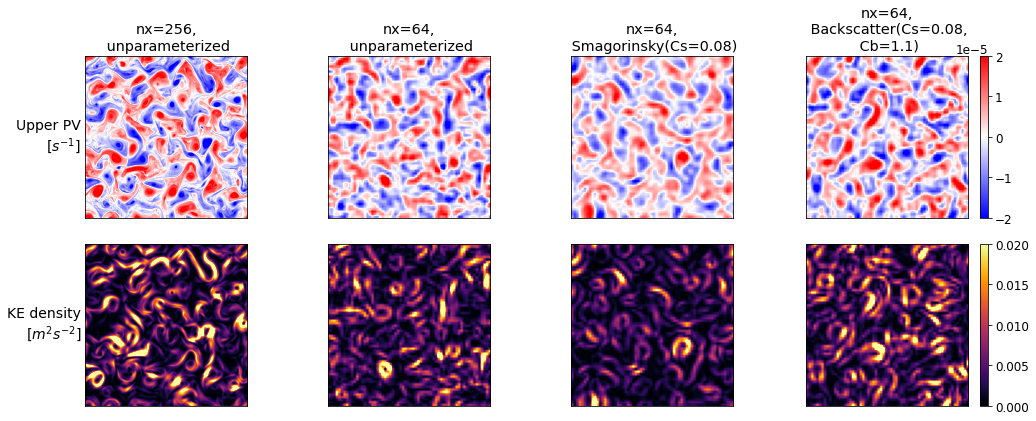

In [7]:
def label_for(sim):
    return f"nx={sim.nx}, {sim.parameterization or 'unparameterized'}"

plt.figure(figsize=(15,6))
plt.rcParams.update({'font.size': 12})
vlim = 2e-5
for i, sim in enumerate([high_res, low_res, smagorinsky, backscatter]):
    plt.subplot(2, 4, i+1, title=label_for(sim).replace(',',",\n").replace('Biharmonic',''))
    plt.imshow(sim.q[0], vmin=-vlim, vmax=vlim, cmap='bwr')
    plt.xticks([]); plt.yticks([])
    if i == 0: plt.ylabel("Upper PV\n[$s^{-1}$]", rotation=0, va='center', ha='right', fontsize=14)
    if i == 3: plt.colorbar()
    
vlim = 2e-2
for i, sim in enumerate([high_res, low_res, smagorinsky, backscatter]):
    plt.subplot(2, 4, i+5)
    plt.imshow((sim.u**2 + sim.v**2).sum(0), vmin=0, vmax=vlim, cmap='inferno')
    plt.xticks([]); plt.yticks([])
    if i == 0: plt.ylabel("KE density\n[$m^2 s^{-2}$]", rotation=0, va='center', ha='right', fontsize=14)
    if i == 3: plt.colorbar()

plt.tight_layout()

Note how these are slightly slower than the baseline low-resolution model, but much faster than the high-resolution model.

See the parameterizations API section and code for examples of how these parameterizations are defined!

## Compute similarity metrics between parameterized and high-resolution simulations

To assist with evaluating the effects of parameterizations, we include helpers for computing similarity metrics between model diagnostics. Similarity metrics quantify the percentage closer a diagnostic is to high resolution than low resolution; values greater than 0 indicate improvement over low resolution (with 1 being the maximum), while values below 0 indicate worsening. We can compute these for all diagnostics for all four simulations:

In [8]:
sims = [high_res, backscatter, low_res, smagorinsky]

pd.DataFrame.from_dict([
    dict(Simulation=label_for(sim),
        **pyqg.diagnostic_tools.diagnostic_similarities(sim, high_res, low_res)) 
    for sim in sims])

,Simulation,Ensspec1,Ensspec2,KEspec1,KEspec2,...,ENSfrictionspec,APEgenspec,APEflux,KEflux,APEgen
0,"nx=256, unparameterized",1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
1,"nx=64, BackscatterBiharmonic(Cs=0.08, Cb=1.1)",0.411546,0.367292,0.461909,0.690354,...,0.444292,0.358023,0.477375,0.525527,0.830839
2,"nx=64, unparameterized",0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
3,"nx=64, Smagorinsky(Cs=0.08)",-0.487918,-0.283741,-0.550229,-0.480562,...,-0.482330,-0.264575,-0.501886,-0.319409,-0.480239


Note that the high-resolution and low-resolution models themselves have similarity scores of 1 and 0 by definition. In this case, the backscatter parameterization is consistently closer to high-resolution than low-resolution, while the Smagorinsky is consistently further.

Let's plot some of the actual curves underlying these metrics to get a better sense:

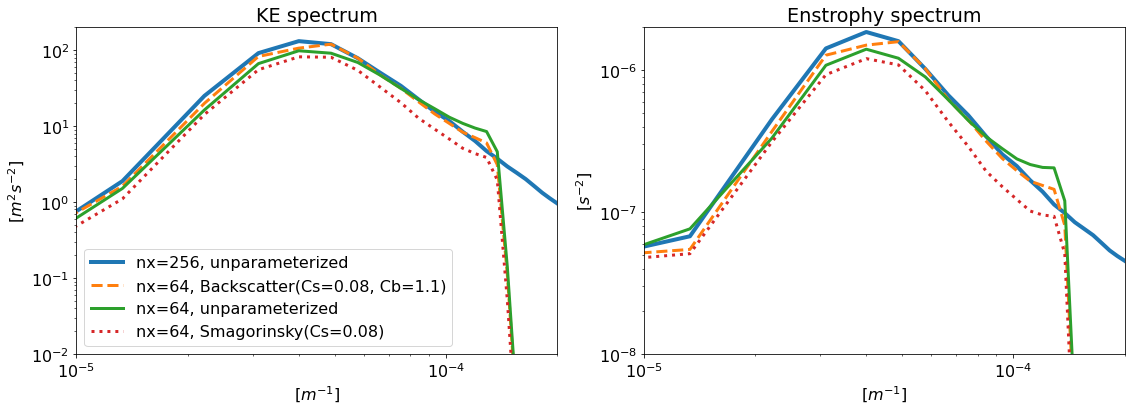

In [9]:
def plot_kwargs_for(sim):
    kw = dict(label=label_for(sim).replace('Biharmonic',''))
    kw['ls'] = (':' if sim.uv_parameterization else ('--' if sim.q_parameterization else '-'))
    kw['lw'] = (4 if sim.nx==256 else 3)
    return kw

def plot_ke_and_enstrophy(sims):
    plt.figure(figsize=(16,6))
    plt.rcParams.update({'font.size': 16})

    plt.subplot(121, title="KE spectrum")
    for sim in sims:
        plt.loglog(
            *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('KEspec').sum(0)),
            **plot_kwargs_for(sim))
    plt.ylabel("[$m^2 s^{-2}$]")
    plt.xlabel("[$m^{-1}$]")
    plt.ylim(1e-2,2e2)
    plt.xlim(1e-5, 2e-4)
    plt.legend(loc='lower left')

    plt.subplot(122, title="Enstrophy spectrum")
    for sim in sims:
        plt.loglog(
            *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('Ensspec').sum(0)),
            **plot_kwargs_for(sim))
    plt.ylabel("[$s^{-2}$]")
    plt.xlabel("[$m^{-1}$]")
    plt.ylim(1e-8,2e-6)
    plt.xlim(1e-5, 2e-4)
    plt.tight_layout()
    
plot_ke_and_enstrophy(sims)

The backscatter model, though low-resolution, has energy and enstrophy spectra that more closely resemble those of the high-resolution model.

In [10]:
def plot_spectra(m):
    m_ds = m.to_dataset().isel(time=-1)
    diag_names_enstrophy = ['ENSflux', 'ENSgenspec', 'ENSfrictionspec', 'ENSDissspec', 'ENSparamspec']
    diag_names_energy = ['APEflux', 'APEgenspec', 'KEflux', 'KEfrictionspec', 'Dissspec', 'paramspec']

    bud_labels_list = [['APE gen','APE flux','KE flux','Bottom drag','Diss.','Param.'], 
                       ['ENS gen','ENS flux','Dissipation','Friction','Param.']]
    title_list = ['Spectral Energy Transfer', 'Spectral Enstrophy Transfer']
    plt.figure(figsize = [15, 5])
    for p, diag_names in enumerate([diag_names_energy, diag_names_enstrophy]):
        bud = []
        for name in diag_names:
            kr, spec = pyqg.diagnostic_tools.calc_ispec(m, getattr(m_ds, name).data.squeeze())
            bud.append(spec.copy())
        plt.subplot(1, 2, p+1)
        [plt.semilogx(kr, term, label=label) for term, label in zip(bud, bud_labels_list[p])]
        plt.semilogx(kr, -np.vstack(bud).sum(axis=0), 'k--', label = 'Resid.')
        plt.legend(loc='best')
        plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
        plt.title(title_list[p])
    plt.tight_layout()

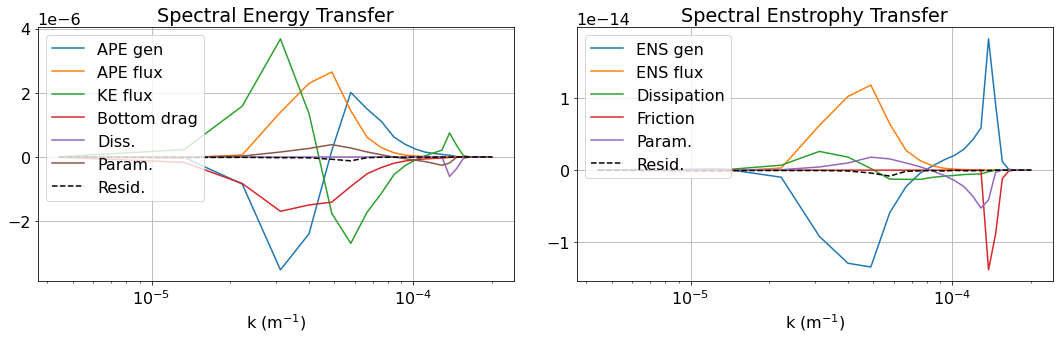

In [11]:
plot_spectra(backscatter)

## Compare all parameterizations

Finally, let's loop through all the parameterizations defined in `pyqg`.

In [13]:
models_by_param = {}
for param_class in pyqg.parameterization_types:
    p = param_class()
    print(p)
    models_by_param[str(p)] = run_parameterized_model(p)

INFO:  Logger initialized


Smagorinsky(Cs=0.1)


INFO: Step: 25000, Time: 9.00e+07, KE: 3.84e-04, CFL: 0.037
INFO:  Logger initialized


BackscatterBiharmonic(Cs=0.08, Cb=0.99)


INFO: Step: 25000, Time: 9.00e+07, KE: 5.73e-04, CFL: 0.045
INFO:  Logger initialized


ZannaBolton2020(κ=-4.68e+07)


INFO: Step: 25000, Time: 9.00e+07, KE: 3.66e-04, CFL: 0.042
INFO:  Logger initialized


HybridSymbolicRLPGZ2022


INFO: Step: 25000, Time: 9.00e+07, KE: 5.63e-04, CFL: 0.045


We can visualize spectra for each (this might get a bit visually overwhelming):

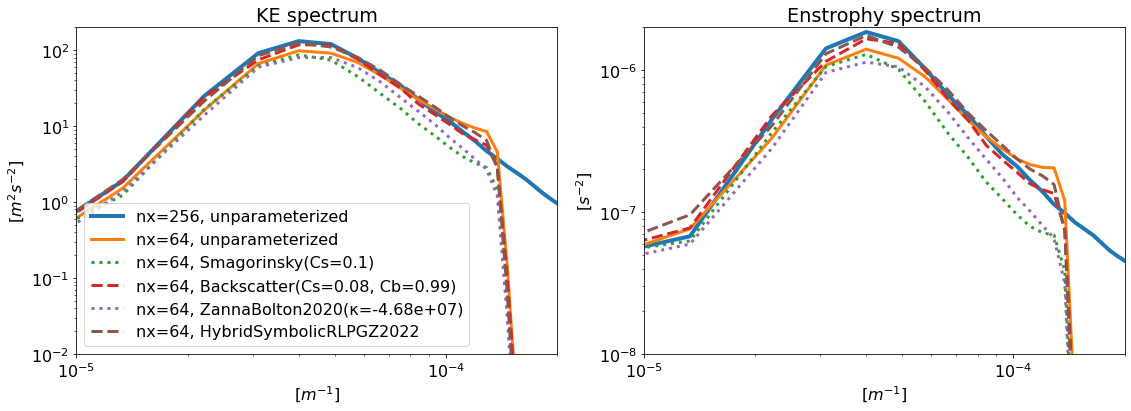

In [14]:
plot_ke_and_enstrophy([high_res, low_res] + list(models_by_param.values()))

Or similarity metrics in tabular form (hopefully a bit less overwhelming):

In [15]:
pd.set_option('display.max_columns', 20)
pd.DataFrame.from_dict([
    dict(Simulation=label_for(sim),
        **pyqg.diagnostic_tools.diagnostic_similarities(sim, high_res, low_res)) 
    for sim in [high_res, low_res] + list(models_by_param.values())])

,Simulation,Ensspec1,Ensspec2,KEspec1,KEspec2,EKEdiss,KEfrictionspec,EKE1,EKE2,Dissspec,ENSDissspec,entspec,ENSflux,ENSgenspec,ENSfrictionspec,APEgenspec,APEflux,KEflux,APEgen
0,"nx=256, unparameterized",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,"nx=64, unparameterized",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"nx=64, Smagorinsky(Cs=0.1)",-0.510277,-0.052414,-0.616761,-0.531477,-0.684091,-0.531477,-1.218244,-0.684091,0.701372,0.702447,-0.962585,0.456639,-0.319162,-0.420016,-0.319162,-0.408622,-0.335664,-0.313803
3,"nx=64, BackscatterBiharmonic(Cs=0.08, Cb=0.99)",0.476413,0.371585,0.554157,0.647160,0.692441,0.647160,0.439888,0.692441,0.321636,0.320155,0.361798,0.103157,0.689095,0.453331,0.689095,0.535633,0.440586,0.980202
4,"nx=64, ZannaBolton2020(κ=-4.68e+07)",-0.497193,-0.646569,-0.489898,-0.205466,-0.326688,-0.205466,-0.909618,-0.326688,0.759999,0.761054,-0.410670,0.486543,-1.305356,-0.350339,-1.305356,-0.641805,-0.313258,-1.483241
5,"nx=64, HybridSymbolicRLPGZ2022",0.593158,0.590983,0.676254,0.818496,0.881938,0.818496,0.738506,0.881938,0.467978,0.471745,0.353234,-0.143199,0.366844,0.627687,0.366844,0.672436,0.577675,0.790370
